## Forecasting when faced with thousands of time series
### Standardize in preparation for calculating distance metrics



In [2]:
from time_series_simulations import time_series_simulations

In [16]:
all_series = time_series_simulations.simulate_ts_population()

In [17]:
all_series.head()

,id,timepoint,amount,process
0,0,0,-0.650442,ar1
1,0,1,0.836030,ar1
2,0,2,1.093406,ar1
3,0,3,-1.770107,ar1
4,0,4,0.898869,ar1


In [18]:
all_series['process'].value_counts()

arima112    11017
ma1         10713
arma21      10649
arima111    10613
arima011    10366
ar2         10219
ma2         10203
arma12      10175
ar1         10119
arma22       9980
arima110     9869
arma11       9792
arima211     9592
arima222     9461
Name: process, dtype: int64

In [19]:
# create unique ids
all_series['id'] = all_series['id'].map(str) + all_series['process'].map(str)

In [20]:
all_series.head()

,id,timepoint,amount,process
0,0ar1,0,-0.650442,ar1
1,0ar1,1,0.836030,ar1
2,0ar1,2,1.093406,ar1
3,0ar1,3,-1.770107,ar1
4,0ar1,4,0.898869,ar1


## Normalize

Min-max normalize across all timepoints across all series vs within each time series - what is the implication?

Normalization will put the values between 0 and 1. I will also standardize the series, so that the mean is 0 and the standard deviation is 1. Standardization assumes that the data fit a Gaussian distribution. 

### With scipy stats and the zscore function

In [16]:
from scipy import stats

In [17]:
all_series['norm_amount'] = stats.zscore(all_series['amount'])

In [18]:
all_series.head()

,id,timepoint,amount,process,norm_amount
0,0ar1,0,-0.650442,ar1,-0.005549
1,0ar1,1,0.431634,ar1,-0.005549
2,0ar1,2,1.352865,ar1,-0.005549
3,0ar1,3,-0.923288,ar1,-0.005549
4,0ar1,4,0.343472,ar1,-0.005549


This doesn't seem to be working, all the values are the same. 

### Normalize by subtracting the mean and dividing by the range 

In [19]:
min_amount = all_series['amount'].min()
max_amount = all_series['amount'].max()

In [20]:
print(min_amount, max_amount)

-9.67691212702153 5.817594386738546e+32


In [21]:
all_series['norm_amount'] = (all_series['amount'] - min_amount) / (max_amount - min_amount)

In [22]:
all_series.head()

,id,timepoint,amount,process,norm_amount
0,0ar1,0,-0.650442,ar1,1.551581e-32
1,0ar1,1,0.431634,ar1,1.737582e-32
2,0ar1,2,1.352865,ar1,1.895934e-32
3,0ar1,3,-0.923288,ar1,1.504681e-32
4,0ar1,4,0.343472,ar1,1.722427e-32


In [23]:
from sklearn.preprocessing import MinMaxScaler

amounts = all_series['amount'].values.reshape(len(all_series['amount']), 1)

scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(amounts)
print(scaler.data_min_, scaler.data_max_)

all_series['scaled_amount'] = scaler.transform(amounts)
all_series.head()

[-9.67691213] [5.81759439e+32]


,id,timepoint,amount,process,norm_amount,scaled_amount
0,0ar1,0,-0.650442,ar1,1.551581e-32,1.551581e-32
1,0ar1,1,0.431634,ar1,1.737582e-32,1.737582e-32
2,0ar1,2,1.352865,ar1,1.895934e-32,1.895934e-32
3,0ar1,3,-0.923288,ar1,1.504681e-32,1.504681e-32
4,0ar1,4,0.343472,ar1,1.722427e-32,1.722427e-32


### Standardize by subtracting the mean and dividing by the standard deviation 

(array([0.0000e+00, 1.2000e+01, 7.0000e+00, 5.4000e+01, 9.7000e+01,
        2.7100e+02, 7.8600e+02, 2.9660e+03, 9.2550e+03, 1.6530e+04,
        1.9308e+04, 1.4070e+04, 8.0880e+03, 4.5970e+03, 3.0120e+03,
        2.2340e+03, 1.8220e+03, 1.7530e+03, 1.7780e+03, 1.5390e+03]),
 array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
          1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 20 Patch objects>)

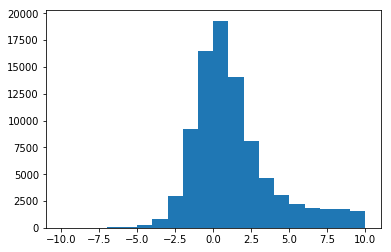

In [31]:
plt.hist(all_series['amount'], range = (-10, 10), bins = 20)

(array([  282., 49004., 32927.,  8544.,  6891.,  6373.,  5043.,  3697.,
         2629.,  2022.,  1563.,  1260.,   949.,   877.,   793.,   763.,
          643.,   544.,   503.,   459.]),
 array([-10. ,  -4.5,   1. ,   6.5,  12. ,  17.5,  23. ,  28.5,  34. ,
         39.5,  45. ,  50.5,  56. ,  61.5,  67. ,  72.5,  78. ,  83.5,
         89. ,  94.5, 100. ]),
 <a list of 20 Patch objects>)

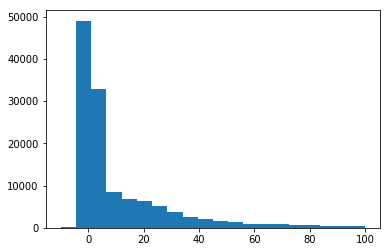

In [33]:
# there is a very long tail on the right, shown here up to 100, but it goes up to 1e+30 
# this may be okay since in the real data the dealers are also operating on different scales 
# (some in the thousands, some in the tens of millions)
plt.hist(all_series['amount'], range = (-10, 100), bins = 20)

In [20]:
all_series['amount'].sort_values()

40    -8.767980e+00
40    -8.693405e+00
41    -8.692874e+00
41    -8.662847e+00
39    -8.543168e+00
41    -8.537284e+00
40    -8.510103e+00
39    -8.420092e+00
41    -8.364694e+00
40    -8.336500e+00
39    -8.094447e+00
41    -8.090648e+00
40    -7.932164e+00
39    -7.681937e+00
41    -7.499885e+00
40    -7.419800e+00
40    -7.111000e+00
39    -7.067218e+00
41    -7.059241e+00
39    -6.987049e+00
166   -6.908817e+00
39    -6.893630e+00
39    -6.815802e+00
39    -6.764464e+00
43    -6.701017e+00
40    -6.668185e+00
40    -6.659425e+00
41    -6.643633e+00
40    -6.643476e+00
38    -6.629514e+00
           ...     
146    3.932345e+27
165    4.087355e+27
167    4.832156e+27
179    5.192289e+27
166    6.076269e+27
147    6.109758e+27
168    7.048186e+27
180    7.425452e+27
167    9.032991e+27
148    9.492846e+27
169    1.028049e+28
181    1.061908e+28
168    1.342846e+28
149    1.474921e+28
170    1.499513e+28
182    1.518627e+28
169    1.996277e+28
183    2.171776e+28
150    2.291613e+28


The range goes all the way up to 1e+30! There is a very, very long right tail to this distribution, across all simulated series. 

Plot each account seprarately to get a better idea of whether standardizing is reasonable. 

First, get a sense of how many of the time series are in those high ranges. 

In [21]:
within_groups = subset_series.groupby('id')['amount'].agg([np.mean, np.std])

In [22]:
within_groups

,mean,std
id,,
12ar2,2.443130e-01,1.161671e+00
12arma21,2.332279e+00,2.677064e+00
13ma2,1.382940e-01,1.113165e+00
18ma2,3.999342e-01,1.416903e+00
21ma2,2.380144e-01,1.463080e+00
23arima111,8.755860e+00,6.028137e+00
33ar1,1.621982e-01,1.134502e+00
34ar2,5.267528e+11,2.027813e+12
36ar2,9.478601e-01,1.642854e+00


In the random sample of 30 series, I see a few with values that are very very high. 

Get z-scores for the column amount within each value for "id". 

In [64]:
grouped = subset_series.groupby('id')

In [66]:
grouped.groups.keys()

dict_keys(['12ar2', '12arma21', '13ma2', '18ma2', '21ma2', '23arima111', '33ar1', '34ar2', '36ar2', '40arima111', '42arima111', '52arima222', '55arima011', '55arima112', '55arma12', '64arma21', '64arma22', '68ma1', '69ar2', '69arma12', '6arma12', '70arma11', '74arma22', '82ma2', '89ma1', '90arima211', '91ma2', '92arma12', '97ar2', '9ar1'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c27d19a20>,
      dtype=object)

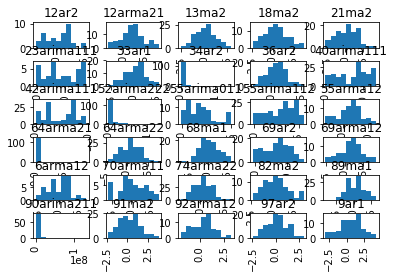

In [70]:
subset_series['amount'].hist(by = subset_series['id'])

Many of them (especially the ones that are within reasonable ranges) seem normally distributed. I could check this with a check for normality, like the Shapiro test, but for now will move on with standardizing. 

### Standardize within each id

In [58]:
series_groups = subset_series.groupby('id')['amount', 'timepoint']

In [59]:
standardized_series = pd.DataFrame()

for key, group in series_groups:
    # get mean and standard deviation within each id
    group_mean = np.mean(group['amount']) 
    group_sd = np.std(group['amount'])
    
    this_sample = pd.DataFrame()
    
    # populated standardized df
    this_sample['id'] = group['id']
    this_sample['timepoint'] = group['timepoint']
    this_sample['amount'] = group['amount']
    this_sample['stand_amount'] = (group['amount'] - group_mean) / group_sd
    
    standardized_series = pd.concat([standardized_series, this_sample])

In [60]:
standardized_series.head()

,id,timepoint,amount,stand_amount
0,12ar2,0,-0.650442,-0.780300
1,12ar2,1,0.796401,0.481466
2,12ar2,2,0.823032,0.504691
3,12ar2,3,-1.336524,-1.378620
4,12ar2,4,1.229389,0.859067


(array([  14.,  390., 1193.,  962.,  366.,   62.,    6.,    5.,    3.,
           2.]),
 array([-3.1855026 , -2.13565191, -1.08580122, -0.03595053,  1.01390017,
         2.06375086,  3.11360155,  4.16345224,  5.21330293,  6.26315362,
         7.31300432]),
 <a list of 10 Patch objects>)

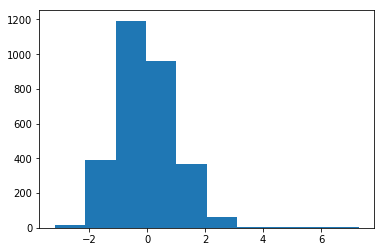

In [61]:
# histogram of all 30 series' standardized amounts 
plt.hist(standardized_series['stand_amount'])

In [62]:
print(standardized_series['stand_amount'].min(), standardized_series['stand_amount'].max())

-3.1855026001764095 7.3130043150636865


In [63]:
standardized_series['id'].value_counts()

74arma22      185
55arima112    164
40arima111    163
52arima222    159
42arima111    140
64arma21      131
89ma1         131
64arma22      129
34ar2         129
91ma2         123
13ma2         118
69ar2         114
68ma1         106
21ma2         104
97ar2          97
36ar2          96
90arima211     85
33ar1          82
12arma21       82
9ar1           78
82ma2          75
18ma2          74
69arma12       69
55arima011     69
92arma12       68
55arma12       68
6arma12        43
70arma11       43
12ar2          39
23arima111     39
Name: id, dtype: int64

In [71]:
standardized_series.head()

,id,timepoint,amount,stand_amount
0,12ar2,0,-0.650442,-0.780300
1,12ar2,1,0.796401,0.481466
2,12ar2,2,0.823032,0.504691
3,12ar2,3,-1.336524,-1.378620
4,12ar2,4,1.229389,0.859067


In [23]:
import pandas as pd
import numpy as np

series_groups = all_series.groupby('id')['amount', 'timepoint']
standardized_series = pd.DataFrame()

for key, group in series_groups:
    # get mean and standard deviation within each id
    group_mean = np.mean(group['amount']) 
    group_sd = np.std(group['amount'])
    
    this_sample = pd.DataFrame()
    
    # populated standardized df
    this_sample['id'] = group['id']
    this_sample['timepoint'] = group['timepoint']
    this_sample['amount'] = group['amount']
    this_sample['stand_amount'] = (group['amount'] - group_mean) / group_sd
    this_sample['process'] = group['process']
    
    standardized_series = pd.concat([standardized_series, this_sample])

In [24]:
standardized_series.head()

,id,timepoint,amount,stand_amount,process
0,0ar1,0,-0.650442,-0.764443,ar1
1,0ar1,1,0.836030,0.569679,ar1
2,0ar1,2,1.093406,0.800676,ar1
3,0ar1,3,-1.770107,-1.769352,ar1
4,0ar1,4,0.898869,0.626078,ar1


In [25]:
ar1_0 = standardized_series[standardized_series['id'] == '0ar1']

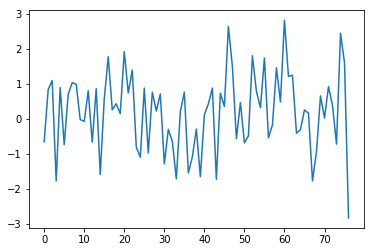

In [27]:
import matplotlib.pyplot as plt
plt.plot(ar1_0['amount'])

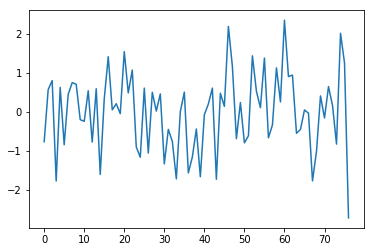

In [28]:
plt.plot(ar1_0['stand_amount'])

(array([ 1.,  4.,  4., 11., 10., 15., 19.,  6.,  4.,  3.]),
 array([-2.82299374, -2.25921241, -1.69543108, -1.13164975, -0.56786843,
        -0.0040871 ,  0.55969423,  1.12347556,  1.68725688,  2.25103821,
         2.81481954]),
 <a list of 10 Patch objects>)

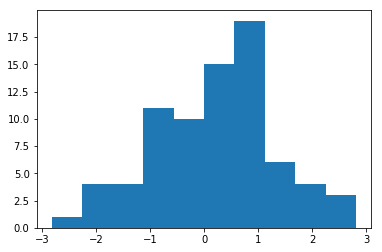

In [49]:
plt.hist(ar1_0['amount'])

(array([ 1.,  4.,  4., 11., 10., 15., 19.,  6.,  4.,  3.]),
 array([-2.71432753, -2.20832873, -1.70232994, -1.19633114, -0.69033235,
        -0.18433356,  0.32166524,  0.82766403,  1.33366283,  1.83966162,
         2.34566042]),
 <a list of 10 Patch objects>)

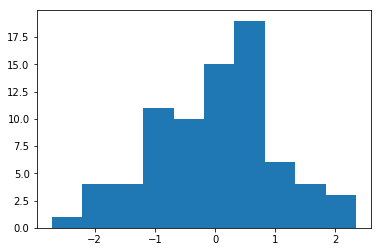

In [50]:
# notice the axis limits change
plt.hist(ar1_0['stand_amount'])

In [30]:
# find a series that has "amount" on a very different scale
all_series.groupby('id')['amount'].agg(np.mean)

id
0ar1          2.012964e-01
0ar2          2.018193e+00
0arima011     1.187683e+01
0arima110     1.218415e+01
0arima111     1.191475e+01
0arima112     1.745983e+01
0arima211     4.023284e+02
0arima222     8.928267e+11
0arma11       2.294000e-01
0arma12       1.112156e+00
0arma21       6.289979e-01
0arma22       1.092400e+00
0ma1          2.790351e-01
0ma2          3.916837e-01
10ar1         1.539382e-01
10ar2         9.073320e-01
10arima011    8.745867e+00
10arima110    2.308188e+01
10arima111    1.366717e+01
10arima112    2.033588e+01
10arima211    2.380760e+02
10arima222    5.033549e+02
10arma11      1.853471e-01
10arma12      2.087118e-01
10arma21      5.673856e+05
10arma22      5.857044e+02
10ma1         1.744596e-01
10ma2         5.280041e-01
11ar1         1.121410e+00
11ar2         2.596463e-01
                  ...     
98ma1         2.467455e-01
98ma2         1.923549e-01
99ar1         9.536458e-01
99ar2         2.898873e+04
99arima011    2.257102e+01
99arima110    1.177480e+0

In [31]:
arima222_9 = standardized_series[standardized_series['id'] == '9arima222']

In [36]:
arima222_9['amount']

0     -6.504417e-01
1     -1.493076e+00
2     -1.361095e+00
3     -1.391161e+00
4     -1.099490e+00
5     -9.805523e-01
6     -4.671962e-01
7      1.684934e+00
8      7.378540e+00
9      1.811210e+01
10     3.577921e+01
11     6.377360e+01
12     1.055533e+02
13     1.671066e+02
14     2.545236e+02
15     3.779582e+02
16     5.529245e+02
17     7.997478e+02
18     1.146271e+03
19     1.630704e+03
20     2.307522e+03
21     3.251111e+03
22     4.564665e+03
23     6.388524e+03
24     8.915828e+03
25     1.241505e+04
26     1.725553e+04
27     2.394865e+04
28     3.320022e+04
29     4.598539e+04
           ...     
71     3.568690e+10
72     4.927707e+10
73     6.804262e+10
74     9.395440e+10
75     1.297338e+11
76     1.791387e+11
77     2.473577e+11
78     3.415557e+11
79     4.716259e+11
80     6.512291e+11
81     8.992282e+11
82     1.241669e+12
83     1.714518e+12
84     2.367436e+12
85     3.268996e+12
86     4.513885e+12
87     6.232848e+12
88     8.606423e+12
89     1.188389e+13


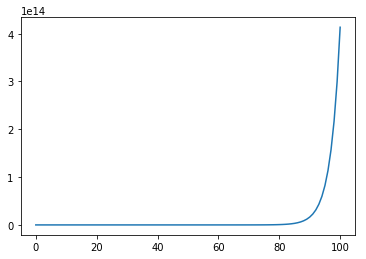

In [37]:
plt.plot(arima222_9['amount'])

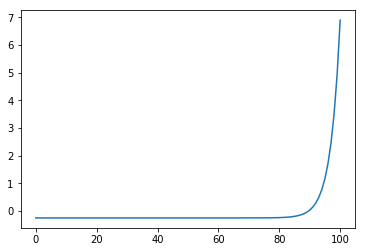

In [38]:
plt.plot(arima222_9['stand_amount'])

(array([93.,  3.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.]),
 array([-1.49307582e+00,  4.13481399e+13,  8.26962797e+13,  1.24044420e+14,
         1.65392559e+14,  2.06740699e+14,  2.48088839e+14,  2.89436979e+14,
         3.30785119e+14,  3.72133259e+14,  4.13481399e+14]),
 <a list of 10 Patch objects>)

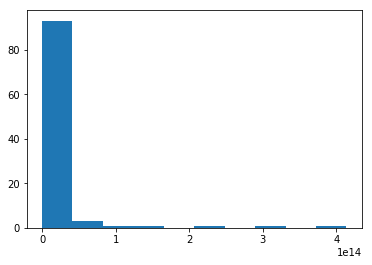

In [47]:
plt.hist(arima222_9['amount'])

(array([93.,  3.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.]),
 array([-0.25687364,  0.4586452 ,  1.17416404,  1.88968287,  2.60520171,
         3.32072055,  4.03623939,  4.75175822,  5.46727706,  6.1827959 ,
         6.89831474]),
 <a list of 10 Patch objects>)

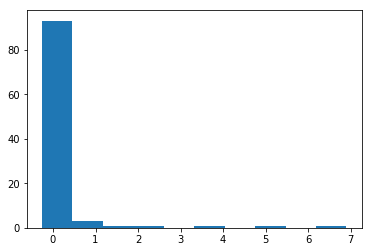

In [48]:
plt.hist(arima222_9['stand_amount'])

In [39]:
# what about min max normalization for these series that have the very large values?
from sklearn.preprocessing import MinMaxScaler

values = arima222_9['amount'].values
values = values.reshape((len(values), 1))

scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(values)

normalized_arima222_9 = scaler.transform(values)

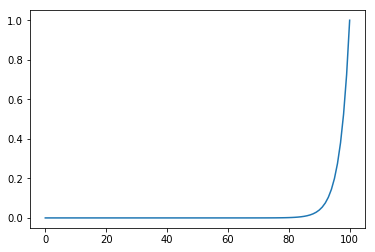

In [44]:
plt.plot(normalized_arima222_9)

(array([93.,  3.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

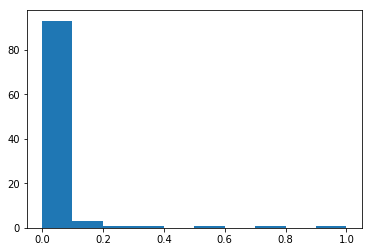

In [51]:
plt.hist(normalized_arima222_9)

### Calculate pairwise distances

In [52]:
standardized_series.head()

,id,timepoint,amount,stand_amount,process
0,0ar1,0,-0.650442,-0.764443,ar1
1,0ar1,1,0.836030,0.569679,ar1
2,0ar1,2,1.093406,0.800676,ar1
3,0ar1,3,-1.770107,-1.769352,ar1
4,0ar1,4,0.898869,0.626078,ar1


In [54]:
# example pair 
one = standardized_series[standardized_series['id'] == '1ar1'][['timepoint', 'amount', 'stand_amount']].sort_values('timepoint')
two = standardized_series[standardized_series['id'] == '10arima011'][['timepoint', 'amount', 'stand_amount']].sort_values('timepoint')

print(one.head())
print(two.head())
print(len(one))
print(len(two))

   timepoint    amount  stand_amount
0          0 -0.650442     -0.752905
1          1  0.638308      0.432046
2          2  1.283088      1.024894
3          3 -1.375899     -1.419932
4          4  0.489297      0.295036
   timepoint    amount  stand_amount
0          0 -0.650442     -1.482808
1          1  0.028252     -1.375705
2          2  1.327663     -1.170648
3          3 -0.182814     -1.409013
4          4  0.281534     -1.335735
53
79


Euclidean distance calculation produces a larger difference than Manhattan distance:

In [56]:
import dtaidistance 
# euclidean distance 
dtaidistance.dtw.distance(np.array(one['stand_amount']), np.array(two['stand_amount']))

6.147257321523286

In [62]:
import fastdtw
# manhattan distance (dist = 1) is more appropriate for high dimensional spaces
distance, path = fastdtw.fastdtw(one[['timepoint', 'stand_amount']], two[['timepoint', 'stand_amount']], dist=1) 

/Users/athenahadjixenofontos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
distance

415.9286623224003

In [64]:
path 
# there is nothing to warp in order to line up these two time series so they are simply paired up until the end, 
#where the last time point of the shorter series is paired up with the remaining timepoints of the longer one

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 20),
 (21, 21),
 (22, 22),
 (23, 23),
 (24, 24),
 (25, 25),
 (26, 26),
 (27, 27),
 (28, 28),
 (29, 29),
 (30, 30),
 (31, 31),
 (32, 32),
 (33, 33),
 (34, 34),
 (35, 35),
 (36, 36),
 (37, 37),
 (38, 38),
 (39, 39),
 (40, 40),
 (41, 41),
 (42, 42),
 (43, 43),
 (44, 44),
 (45, 45),
 (46, 46),
 (47, 47),
 (48, 48),
 (49, 49),
 (50, 50),
 (51, 51),
 (52, 52),
 (52, 53),
 (52, 54),
 (52, 55),
 (52, 56),
 (52, 57),
 (52, 58),
 (52, 59),
 (52, 60),
 (52, 61),
 (52, 62),
 (52, 63),
 (52, 64),
 (52, 65),
 (52, 66),
 (52, 67),
 (52, 68),
 (52, 69),
 (52, 70),
 (52, 71),
 (52, 72),
 (52, 73),
 (52, 74),
 (52, 75),
 (52, 76),
 (52, 77),
 (52, 78)]

In [65]:
# euclidean distance with fastdtw to compare implementations
from scipy.spatial.distance import euclidean
euc_dist, euc_path = fastdtw.fastdtw(one, two, dist = euclidean)
print(euc_dist)
print(euc_path)

812.0150294133322
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 43), (44, 44), (45, 45), (46, 46), (46, 47), (47, 48), (47, 49), (47, 50), (48, 51), (49, 52), (49, 53), (50, 54), (51, 55), (52, 56), (52, 57), (52, 58), (52, 59), (52, 60), (52, 61), (52, 62), (52, 63), (52, 64), (52, 65), (52, 66), (52, 67), (52, 68), (52, 69), (52, 70), (52, 71), (52, 72), (52, 73), (52, 74), (52, 75), (52, 76), (52, 77), (52, 78)]


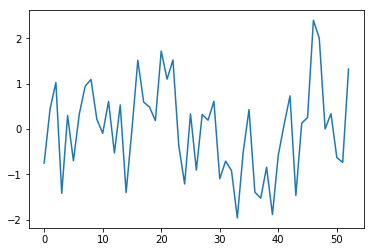

In [66]:
plt.plot(one['timepoint'], one['stand_amount'])

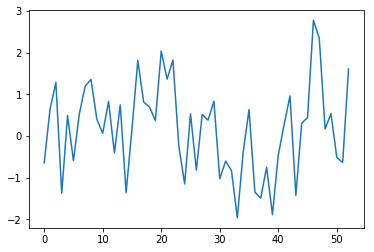

In [67]:
plt.plot(one['timepoint'], one['amount'])

Would it be more appropriate to standardize all series together? No, they are different processes. 

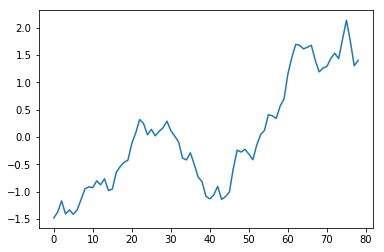

In [68]:
plt.plot(two['timepoint'], two['stand_amount'])

In [69]:
# the path is different if euclidian distance is taken 
# does this make sense? yes
dtai_path = dtaidistance.dtw.warping_path(one['stand_amount'], two['stand_amount'])
dtai_path

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (1, 20),
 (2, 20),
 (3, 20),
 (4, 20),
 (5, 20),
 (6, 21),
 (7, 22),
 (8, 22),
 (9, 23),
 (10, 23),
 (11, 23),
 (12, 24),
 (13, 25),
 (14, 26),
 (15, 27),
 (15, 28),
 (16, 29),
 (17, 29),
 (18, 29),
 (19, 29),
 (20, 29),
 (21, 29),
 (22, 29),
 (23, 30),
 (23, 31),
 (23, 32),
 (23, 33),
 (24, 34),
 (25, 35),
 (26, 35),
 (27, 35),
 (28, 35),
 (29, 35),
 (30, 36),
 (31, 37),
 (32, 38),
 (32, 39),
 (33, 40),
 (34, 41),
 (35, 42),
 (36, 43),
 (37, 43),
 (38, 44),
 (39, 45),
 (40, 46),
 (40, 47),
 (40, 48),
 (41, 49),
 (42, 50),
 (43, 51),
 (44, 52),
 (44, 53),
 (44, 54),
 (45, 55),
 (45, 56),
 (45, 57),
 (45, 58),
 (46, 59),
 (47, 59),
 (48, 59),
 (49, 59),
 (50, 59),
 (51, 59),
 (52, 60),
 (52, 61),
 (52, 62),
 (52, 63),
 (52, 64),
 (52, 65),
 (52, 66),
 (52, 67),
 (52, 68),
 (52, 69),
 (52, 70),
 (52,

In [72]:
# plot warping with fastdtw manhattan distances 
from dtaidistance import dtw_visualisation as dtwvis
dtwvis.plot_warping(one['stand_amount'], two['stand_amount'], path, filename = "one_two_warp_manhattan_fastdtw.png")

(None, None)

<img src = "one_two_warp_manhattan_fastdtw.png">

In [73]:
# plot warping path with dtaidistance euclidean distances 
dtwvis.plot_warping(one['stand_amount'], two['stand_amount'], dtai_path, filename = "one_two_warp_euc_dtaidistance.png")

(None, None)

<img src = "one_two_warp_euc_dtaidistance.png">

In [74]:
# plot warping path with fastdtw euclidean distances 
dtwvis.plot_warping(one['stand_amount'], two['stand_amount'], euc_path, filename = "one_two_warp_euc_fastdtw.png")

(None, None)

<img src = "one_two_warp_euc_fastdtw.png">

### Distance calculations between unstandardized series

In [75]:
euc_dist_not_scaled, euc_path_not_scaled = fastdtw.fastdtw(one[['timepoint', 'amount']], two[['timepoint', 'amount']], dist = euclidean)
print(euc_dist_not_scaled)
print(euc_path_not_scaled)

792.2078315370145
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 43), (44, 44), (45, 45), (46, 46), (46, 47), (46, 48), (47, 49), (47, 50), (47, 51), (48, 52), (49, 53), (50, 54), (51, 55), (52, 56), (52, 57), (52, 58), (52, 59), (52, 60), (52, 61), (52, 62), (52, 63), (52, 64), (52, 65), (52, 66), (52, 67), (52, 68), (52, 69), (52, 70), (52, 71), (52, 72), (52, 73), (52, 74), (52, 75), (52, 76), (52, 77), (52, 78)]


In [76]:
dtwvis.plot_warping(one['amount'], two['amount'], euc_path_not_scaled, filename = "one_two_warp_euc_not_scaled_fastdtw.png")

(None, None)

<img src = "one_two_warp_euc_not_scaled_fastdtw.png">

In [77]:
dtai_path_not_scaled = dtaidistance.dtw.warping_path(one['amount'], two['amount'])

In [78]:
# plot warping path with dtaidistance euclidean distances and unscaled amounts
dtwvis.plot_warping(one['amount'], two['amount'], dtai_path, filename = "one_two_warp_euc_not_scaled_dtaidistance.png")

(None, None)

<img src = "one_two_warp_euc_not_scaled_dtaidistance.png">

Observations:  

* Fastdtw seems to warp the series much less
   * Try it with a pair that looks more similar to see whether the less warping is appropriate
* The z-score amounts seems to not affect this one example (note that a quantitative comparison has yet to be done). Given the strength of the literature FOR standardizing, I will keep the z-score standardization for all of the distance calculations. 
   * Note that the scales here were relatively similar. For the series that are in 1e14 scales, the comparison will be different. 